<a href="https://colab.research.google.com/github/Yang-star-source/BasicDiffusionUnet/blob/main/BasicDiffusionUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to train a diffusion model ?

The first step is to add noice on images , randomly.

However , this random noices follow the normal distribution.

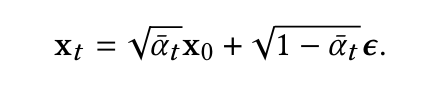

The above formula is from DDPM (Denoising Diffusion Probabilistic Model) paper , emphasize that the noised_images at timestep t , equal to sqrt of cumulative_alpha * clean_img + sqrt(1-cum_alpha) * epsilon.

Where epsilon ~ N(0,I) where I = identity matrix

Gnerally , we can generate random noised images with noice follow the normal distribution (mean=0 , variance = 1)

(810, 807, 4)


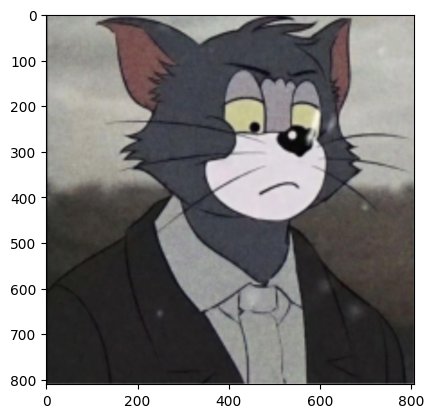

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = np.array(Image.open("tom.png"))
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))
     ])

img = np.array(Image.open("tom.png"))
img = transform(img)

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1.0 - betas
alphas_cum = torch.cumprod(alphas,dim=0)  # dim dont have default  ,need to specify
sqrt_alphas_cum = torch.sqrt(alphas_cum)
sqrt_one_minus_alphas_cum = torch.sqrt(1.0 - alphas_cum)

def add_noice(t):
  t = t

  noices = torch.randn_like(img)

  noised_img = sqrt_alphas_cum[t] * img + sqrt_one_minus_alphas_cum[t] * noices

  # .permute(1, 2, 0) moves:
  # Dimension 1 (Height) -> to Position 0
  # Dimension 2 (Width)  -> to Position 1
  # Dimension 0 (Color)  -> to Position 2
  # Move channels to back -> Shift range from [-1, 1] to [0, 1]
  viewable_img = noised_img.permute(1, 2, 0)
  viewable_img = (viewable_img + 1) / 2  # Un-normalize
  viewable_img = viewable_img.clamp(0, 1) # Force strict 0-1 range just in case
  return viewable_img



We can visualize the noisy image in any timestep , **reminder** : the process of adding noice does **not depends** on previous image.

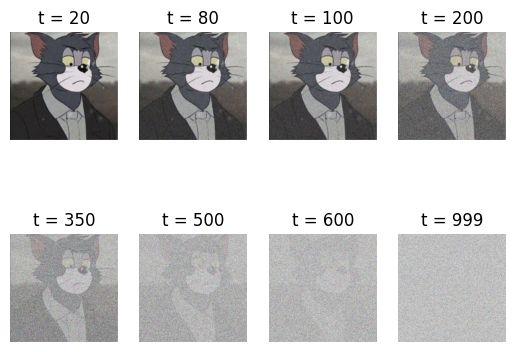

In [ ]:
import matplotlib.pyplot as plt

time = [20,80,100,200,350,500,600,999]
fig , ax = plt.subplots(2,4)
for i in range(8):
  if i < 4:
    ax[0,i].imshow(add_noice(time[i]))
    ax[0,i].axis('off')
    ax[0,i].set_title(f"t = {time[i]}")
  else:
    ax[1,i-4].imshow(add_noice(time[i]))
    ax[1,i-4].axis('off')
    ax[1,i-4].set_title(f"t = {time[i]}")

plt.show()


Time embedding is crucial in order to let model to "understand" time. It is a tips to let model to guess roughly amount of noices based on time given. For example , if we tell model "the given images is from time = 1" means that the image might consist only little of noices , avoid too much error. Sinusoidal time embedding is used based on DDPM paper.

The overall flow of how time is embedded and insert into Unet:

1) generate raw embedding time (frequency) by using a self-define function (raw_time_embedding) , input (time,t and time dimention, dim)

2) The raw embedded time pass to class TimeEmbedding to study and control

3) Embedded time finally will fit the out_channels X after conv2d , means use nn.Linear to convert tim_emb_dim to out_channels

4) When the shape of embedded time and out_channels X match , add them

In [ ]:
def raw_time_embedding(time , dim):
  if not torch.is_tensor(time):
    time = torch.tensor(time)

  device=time.device
  if time.ndim == 0:
    time = time.unsqueeze(0).unsqueeze(1)
  else:
    time = time.unsqueeze(1)

  # important to specify device
  i=torch.arange(dim//2,device=device).float()
  obj = (time)/(10000**(2*i/dim))
  return torch.cat([torch.sin(obj),torch.cos(obj)],dim=1)



**Diffusion Unet** will be used. Unlike basic Unet architecture with only one input (image) . We have 2 input (time ,image). The output for our model is noices of the given images. Hence , the generated image = input image - noices predicted.

**Basic Unet architecture :**

def conv_block (conv2d -> relu -> conv2d -> relu)

**Diffusion Unet architecture :**

def conv_block (conv2d -> time_emb -> relu -> conv2d -> relu)

That's it , the key different is time.

For more advanced training , we could have attention layer , groupnorm etc.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets


class time_embedding(nn.Module):
  def __init__(self,dim):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(dim,dim),
        nn.SiLU(),
        nn.Linear(dim,dim)
    )

  def forward(self,X):
    return self.net(X)

class conv_block (nn.Module):
  def __init__(self,in_channels,out_channels,time_emb_dim):
    super().__init__()
    self.c1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
    self.c2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
    self.act = nn.ReLU()

    # time projection is to project the embedded time to conv2d
    self.time_proj = nn.Sequential(
        nn.SiLU(),
        nn.Linear(time_emb_dim,out_channels)
    )

  def forward(self,X,time_emb):
    X=self.c1(X)
    emb = self.time_proj(time_emb)
    emb = emb[:,:,None,None]
    X=X+emb
    X=self.act(X)
    X=self.c2(X)
    X=self.act(X)
    return X

# Since the maxpool is make the image half 4 times in codes,
# Hence, the size of input image should be divisible by 2**4=16
class DiffusionUnet(nn.Module):
  def __init__(self):
    super().__init__()

    self.time_dim = 256   # can set any
    self.time_mlp = time_embedding(self.time_dim)

    self.conv1 = conv_block(3,64,self.time_dim)
    self.conv2 = conv_block(64,128,self.time_dim)
    self.conv3 = conv_block(128,256,self.time_dim)
    self.conv4 = conv_block(256,512,self.time_dim)

    self.maxpool = nn.MaxPool2d(2)

    self.bottleneck = conv_block(512,1024,self.time_dim)

    self.conv_transpose1 = nn.ConvTranspose2d(1024,512,2,2)
    self.conv5 = conv_block(1024,512,self.time_dim)

    self.conv_transpose2 = nn.ConvTranspose2d(512,256,2,2)
    self.conv6 = conv_block(512,256,self.time_dim)

    self.conv_transpose3 = nn.ConvTranspose2d(256,128,2,2)
    self.conv7 = conv_block(256,128,self.time_dim)

    self.conv_transpose4 = nn.ConvTranspose2d(128,64,2,2)
    self.conv8 = conv_block(128,64,self.time_dim)

    self.out = nn.Conv2d(64,3,kernel_size=1)

  def forward(self,X,time):
    time_emb = raw_time_embedding(time,self.time_dim)
    time_emb = self.time_mlp(time_emb)

    d1 = self.conv1(X,time_emb)
    p1 = self.maxpool(d1)

    d2 = self.conv2(p1,time_emb)
    p2 = self.maxpool(d2)

    d3 = self.conv3(p2,time_emb)
    p3 = self.maxpool(d3)

    d4 = self.conv4(p3,time_emb)
    p4 = self.maxpool(d4)

    bottleneck = self.bottleneck(p4,time_emb)

    u1 = self.conv_transpose1(bottleneck)
    u1 = torch.cat((u1,d4),dim=1)
    u1 = self.conv5(u1,time_emb)

    u2 = self.conv_transpose2(u1)
    u2 = torch.cat((u2,d3),dim=1)
    u2 = self.conv6(u2,time_emb)

    u3 = self.conv_transpose3(u2)
    u3 = torch.cat((u3,d2),dim=1)
    u3 = self.conv7(u3,time_emb)

    u4 = self.conv_transpose4(u3)
    u4 = torch.cat((u4,d1),dim=1)
    u4 = self.conv8(u4,time_emb)

    out = self.out(u4)

    return out



In [ ]:

# ToTensor convert [0,255] to [0,1]
# We need to use normal distribution to convert [0,1] to [-1,1]
# why ? because we need to match the gaussion noice , it's also [-1,1]
# how ? recall z= (input - mean) / standard_deviation
# when input = 0 , z = -1 , when input = 1 , z = 1
# solve the simultaneous equation we get mean = standard_deviation = 0.5
# since our image shape is RGB * H * W , we need to convert all 3 color channel
# hence we do 3 normalization with same mean and standard_deviation
# torch.Normalize(mean,standard_deviation)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

dataset = datasets.CIFAR10(root="./data",train=True,transform=transform,download=True)

train_loader = DataLoader(dataset,batch_size=32,shuffle=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
model=DiffusionUnet().to(DEVICE)
EPOCHS = 50
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

betas = torch.linspace(beta_start, beta_end, timesteps).to(DEVICE)
alphas = 1.0 - betas
alphas_cum = torch.cumprod(alphas,dim=0)  # dim dont have default  ,need to specify
sqrt_alphas_cum = torch.sqrt(alphas_cum)
sqrt_one_minus_alphas_cum = torch.sqrt(1.0 - alphas_cum)

print("Start Learning")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for data,_ in train_loader:
        img=data.to(DEVICE)
        batch_size=img.shape[0]

        # follow normal distribution with mean = 0 , variance = 1
        noices = torch.randn_like(img)

        # this will generate torch.tensor([random numbers])
        t=torch.randint(0,timesteps,(batch_size,)).to(DEVICE)

        noised_img = (sqrt_alphas_cum[t][:,None,None,None] * img) + (sqrt_one_minus_alphas_cum[t][:,None,None,None] * noices)

        optimizer.zero_grad()
        estimated_noice=model(noised_img,t)
        loss=loss_fn(estimated_noice,noices)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_epoch_loss = running_loss / len(train_loader)
    print(f"--- Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_epoch_loss:.4f} ---")

SAVE_PATH = "diffusion.pth"
torch.save(model.state_dict(), SAVE_PATH)

print(f"Model saved to {SAVE_PATH}")



100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]
/tmp/ipython-input-1990011898.py:19: DeprecationWarning: Use torch_xla.device instead
  DEVICE = xm.xla_device()


xla:0
Start Learning


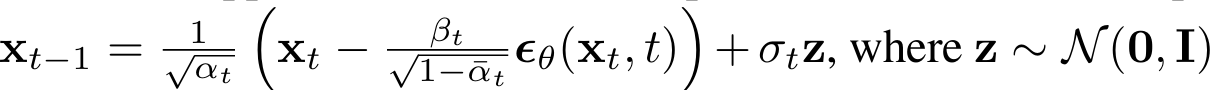

The above formula is the denoising formula introduced in DDPM paper.

In [ ]:
import matplotlib.pyplot as plt

def sample_and_show(model, epoch):
    print(f"Sampling at Epoch {epoch}...")
    model.eval() # Switch to evaluation mode

    # Start with Pure Random Noise (Standard Normal)
    # CIFAR-10 is 32x32. We generate 8 images to look at.
    img_size = 32
    n_images = 8
    x = torch.randn(n_images, 3, img_size, img_size).to(DEVICE)

    with torch.no_grad():
        # Loop Backwards from T=999 to 0
        for i in reversed(range(timesteps)):
            t = torch.tensor([i] * n_images).to(DEVICE) # Create batch of time 'i'

            predicted_noise = model(x, t)

            # Get the math constants for this specific time step 't'
            alpha = alphas[t][:, None, None, None]
            alpha_cum = alphas_cum[t][:, None, None, None]
            beta = betas[t][:, None, None, None]

            # Create noise for the stochastic part (sigma * z)
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x) # No noise added at the very last step (t=0)

            # Denoising formula
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_cum))) * predicted_noise) + torch.sqrt(beta) * noise

    model.train() # Switch back to training mode

    # Post-processing for Display
    # Convert [-1, 1] back to [0, 1] for matplotlib
    x = (x.clamp(-1, 1) + 1) / 2

    # Move to CPU and reshape , matplotlib require color channel at back
    x = x.cpu().permute(0, 2, 3, 1).numpy() # [Batch, H, W, C]

    plt.figure(figsize=(10, 2))
    for k in range(n_images):
        plt.subplot(1, n_images, k+1)
        plt.imshow(x[k])
        plt.axis('off')
    plt.suptitle(f"Generated at Epoch {epoch}")
    plt.show()

Sampling at Epoch Final...


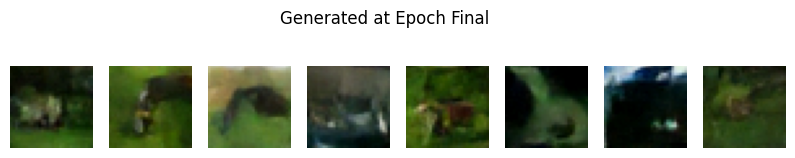

In [ ]:
# Load Model
model = DiffusionUnet().to(DEVICE)
model.load_state_dict(torch.load("diffusion.pth"))

# Run Sampler
sample_and_show(model, "Final")

The generated image seems like blurry and quite hard to recognize.
How to improve this basic Unet ?

- Change ReLU to SiLU , since the derivation of ReLU is either 0 or 1 , hence when take the partial derivative of loss regarding to first weight , it is possible to be 0

- Use resnet y=x+f(x) , this recursive function ensure there exist gradient >= 1 will be passed to the first weight even if the layer is going deeply. Means that ensure every weight can learn based on loop.

- Add attention layer , self-attention enable model to find the similar number and score the similarity. This is the key to have high resolution image generated.

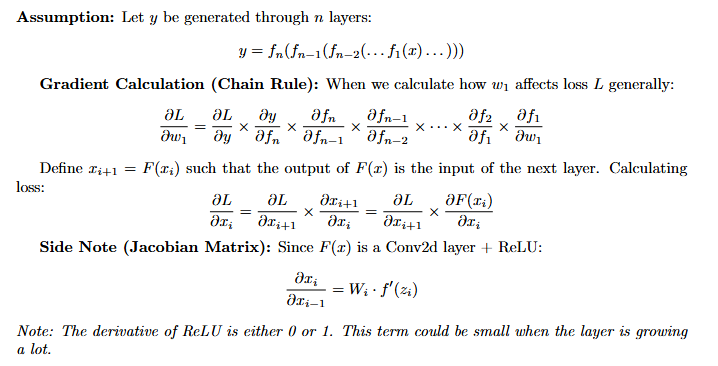

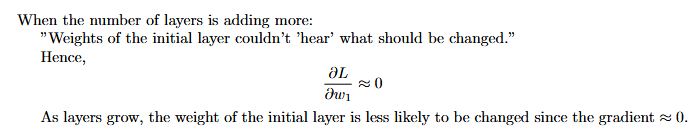

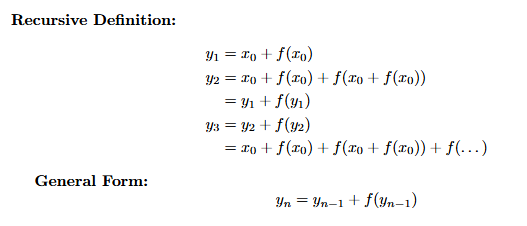

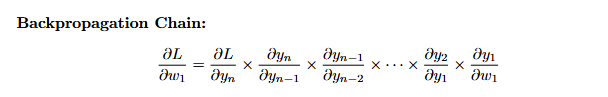

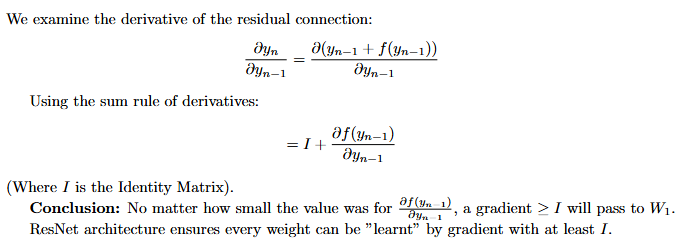

The above mathematical formula shows why we need ResNet instead of purely conv2d + relu repeatedly